In [1161]:
import numpy as np
import pandas as pd 
import netCDF4
from netCDF4 import Dataset
import geopandas as gpd

import sklearn
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import nbimporter
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Conv1D, Conv2D,Dense, Dropout, Input, Concatenate, MaxPooling1D, BatchNormalization
import tensorflow.keras

from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.layers import Dense, Activation, Concatenate
from keras.callbacks import ModelCheckpoint
import h5py
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd 
import netCDF4
from netCDF4 import Dataset
import geopandas as gpd
import sklearn
import warnings
warnings.filterwarnings("ignore")
import nbimporter
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.layers import Conv1D,Dense, Dropout, Input
import tensorflow.keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.layers import Dense, Activation, Concatenate
from keras.callbacks import ModelCheckpoint
import h5py
from keras.models import load_model
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit
import json
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline
import matplotlib.pyplot as plt


cultures = {}
with open('lexique_cultures.json') as file:
    cultures = json.load(file)

In [1231]:
%run -i geoprocessing.py
rand_state=np.random.randint(50)

In [1163]:
path_departments ='Geojson_files/contour-des-departements.geojson'
French_departments = gpd.read_file(path_departments)
regions_names,geometries,code_list=geojson_extract(French_departments,np.arange(len(French_departments)),'nom','geometry','code')
geojson_columns= {'Region Name': regions_names, 'Geometry':geometries,'code':code_list}
Regions=gpd.GeoDataFrame(geojson_columns)
regs_to_remove=['Paris','Haute-Corse','Corse-du-Sud']

Regions, reg_names, code_list = remove_regions(Regions,regs_to_remove)
reg_names = replace_substring(reg_names)

### Retrieving processed data 

In [1164]:
nb_years_tot=23
data_matrix_load = np.loadtxt("data_matrix_departments.txt")

data_features=['u10', 'v10', 't2m', 'evabs', 'evatc', 'evavt','src', 'stl1', 'sp', 'e', 'tp', 'swvl1']
Nb_examples = len(Regions) * nb_years_tot
data_matrix_init= data_matrix_load.reshape(
    data_matrix_load.shape[0], data_matrix_load.shape[1] //  len(data_features), len(data_features))
data_matrix_init=data_matrix_init.reshape((Nb_examples,365,len(data_features)))

# Partie choix paramètres

In [1204]:
# Choix de la culture :

nb_experiments=1

culture_num=152

year_choice=2013
# [2021,2022]

test_score=False
data_test_size=0.1

#This will give us a score for test_size  if True

# Mettre False rendra les évaluations déterministes i.e même données d'entraînement, même données de test (utiles pour test de score avec d'autres paramètres), 
# Mettre True rendra les évaluations non déterministes

random = True
# [True,False]


feature_choice=[0,2,8,10]
# feature_choice=[0,1,2,3,4,5,6,7,8,9,10,11]
# data_features=['u10', 'v10', 't2m', 'evabs', 'evatc', 'evavt','src', 'stl1', 'sp', 'e', 'tp', 'swvl1']


#Nombre d'itérations d'entraînement
nb_epochs=30
# [20 to 35]

#Départ de l'enregistrement de loss minimal trouvé
start_loss_checkpoint=15
# [8 to 15 ]


# Paramètres de l'optimiseur
optimizer_centering=False
#True,False
Verbose=0
portions=np.arange(0.2,2.0,0.02)
# portions=np.arange(1,1.1)

In [1205]:
import json
cultures = {}
with open('lexique_cultures.json') as file:
    cultures = json.load(file)
culture_name=cultures[str(culture_num)]
culture_name


'Bl tendre de printemps'

In [1206]:
# 151,152

In [1207]:

#Données production, année début / année fin
year_start=2000
year_finish=2020

#Ensemble des années représentées en données de production
years_data=np.arange(year_start,year_finish+1,1)

#Lecture du fichier excel de production d'une culture

    
rendement = pd.read_excel('Production data/cultures_2000_2020/rendement/culture_'+str(culture_num)+'Rendement'+'.xlsx')


#Removing column name
reg_rep=np.delete(np.asarray(rendement.columns),0)

x_max_region,x_min_region,std_xmax,std_xmin,val_olymp_region,olymp_abs,mean_regions=gen_std_prod(years_data,rendement,reg_rep)

reg_filt = find_indices(code_list, reg_rep)


  
portions_min=np.round(np.mean(x_min_region),2)
portions_max=np.round(np.mean(x_max_region),2)



xlim_min=min(x_min_region)+0.1
xlim_max=max(x_max_region)-0.1

# portions=np.arange(xlim_min,xlim_max,0.01)
# portions=np.arange(0.3,2.0,0.02)

# portions=np.arange(min(x_min_region)+std_xmin,max(x_min_region)-std_xmax)
# portions=np.arange(portions_min,portions_max,0.05)

In [1208]:
rendement.columns

Index(['Dept', '02', '04', '10', '19', '28', '87', '05', '36', '37', '41',
       '45', '50', '51', '54', '59', '60', '61', '62', '80', '90', '86', '88',
       '23'],
      dtype='object')

In [1209]:
## Getting predictions and probabilities of loss of production

In [1210]:
year_data_start=2000
drop_out_rate=0.1
outlayer_neurons=128

loss_histories=[]

year_pick=int(year_choice-year_data_start)
pick_years=[year_pick]
for reg in range(1,len(reg_filt)):
    pick_years.append(year_pick+len(years_data)*reg)

tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    centered=optimizer_centering,
    use_ema=False,
    name="RMSprop",
)
f1=[]
for experiment in range(nb_experiments):

    
    for portion in portions : 
            print(portion)
            if random == True:
                rand_state=np.random.randint(50)
            #Construction et définition du réseau de neurones 
            labels=gen_labels_portion_4(years_data,rendement,reg_rep,portion)
            data_matrix=region_year_filter(reg_filt,years_data,nb_years_tot,data_matrix_init,24,feature_choice)
            if year_pick<len(years_data):

                data_matrix=np.delete(data_matrix,pick_years,axis=0)
                labels=np.delete(labels,pick_years,axis=0)
            nb_regions=len(Regions) 

           

            model = Sequential([

                  layers.Conv1D(256, 14, padding='same', activation='relu', input_shape=(365,len(feature_choice))),
                  layers.MaxPooling1D(pool_size=8),
                  layers.Dropout(drop_out_rate),
                  layers.Conv1D(128, 4, padding='same', activation='relu'),
                  layers.MaxPooling1D(pool_size=6),
                  layers.Dropout(drop_out_rate),
                  layers.Conv1D(64, 2, padding='same', activation='relu'),
                  layers.MaxPooling1D(pool_size=4),
                  layers.Dropout(drop_out_rate),
                  layers.Flatten(),
                  layers.Dense(outlayer_neurons, activation='relu'),
                  layers.Dense(2,activation='softmax')

            ])


            #Compilation du modèle
            model.compile(optimizer='RMSProp',loss='CosineSimilarity',metrics='binary_accuracy')

            #Séparation des données test et entraînement
            if test_score==True:
                x_train, x_test, y_train, y_test = train_test_split(data_matrix,to_categorical(labels), test_size=data_test_size,random_state=rand_state)

            else:
                x_train, x_test, y_train, y_test = train_test_split(data_matrix,to_categorical(labels), test_size=0.01,random_state=rand_state)

            mc = ModelCheckpoint('Test_weights/'+str(culture_num)+'_best_model_'+str(portion*100)+'.h5', monitor='val_loss', mode='min', verbose=0,save_best_only=True,start_from_epoch=start_loss_checkpoint)

            history=model.fit(x_train, y_train,
                                epochs=nb_epochs,
                                batch_size=4,verbose=Verbose,class_weight=weights(labels,'binary'),validation_split=0.25,callbacks=[mc])
            

            saved_model = load_model('Test_weights/'+ str(culture_num)+'_best_model_'+str(portion*100)+'.h5')
            
            min_loss_history=min(history.history['val_loss'])
            loss_histories.append(min_loss_history)
            
            if test_score==True:
                
                prob_class=saved_model.predict(x_test)
                pred_labels=[]
                y_true=[]
                for prob in prob_class:
                    pred_labels.append(np.argmax(prob))

                for example in range(len(y_test)):
                    y_true.append(np.argmax(y_test[example]))

                f1.append(f1_score(y_true,pred_labels))
                
if test_score==True : 

    print('Score de classification')
    print(np.round(np.mean(f1)*100,2),'+-',np.round(np.std(f1)*100,2),'%')


0.2
0.22
0.24
0.26
0.27999999999999997
0.29999999999999993
0.31999999999999995
0.33999999999999997
0.35999999999999993
0.3799999999999999
0.3999999999999999
0.41999999999999993
0.4399999999999999
0.4599999999999999
0.47999999999999987
0.49999999999999983
0.5199999999999998
0.5399999999999998
0.5599999999999998
0.5799999999999998
0.5999999999999999
0.6199999999999999
0.6399999999999998
0.6599999999999997
0.6799999999999997
0.6999999999999997
0.7199999999999998
0.7399999999999998
0.7599999999999998
0.7799999999999998
0.7999999999999996
0.8199999999999996
0.8399999999999996
0.8599999999999997
0.8799999999999997
0.8999999999999997
0.9199999999999997
0.9399999999999997
0.9599999999999995
0.9799999999999995
0.9999999999999996
1.0199999999999996
1.0399999999999996
1.0599999999999996
1.0799999999999996
1.0999999999999996
1.1199999999999994
1.1399999999999995
1.1599999999999995
1.1799999999999995
1.1999999999999995
1.2199999999999995
1.2399999999999995
1.2599999999999993
1.2799999999999994
1.29

In [1211]:
# year_choice=2013

years_tot=np.arange(2000,2023,1)
data_matrix2=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_init,24,feature_choice)
year_pick=int(year_choice-year_data_start)


pick_years=[year_pick]
for reg in range(1,len(reg_filt)):
    pick_years.append(year_pick+nb_years_tot*reg)

test_year_data=data_matrix2[pick_years]

test_year_data.shape

(23, 365, 4)

In [1212]:
# #Génération des prédictions
prob_csv=[]
for portion in portions : 
        
        saved_model = load_model('Test_weights/'+str(culture_num)+'_best_model_'+str(portion*100)+'.h5')
        
        predictions=np.round(np.asarray(saved_model.predict(test_year_data))[:,1],2)
        prob_csv.append(predictions)

Columns=np.asarray(reg_rep)
prob_csv=pd.DataFrame(prob_csv,columns=Columns,index=portions)


1/1 [==============================] - 0s 204ms/step


In [ ]:
## Getting predictions and probabilities of loss of production

Prédiction de la production la plus probable: 96.02%


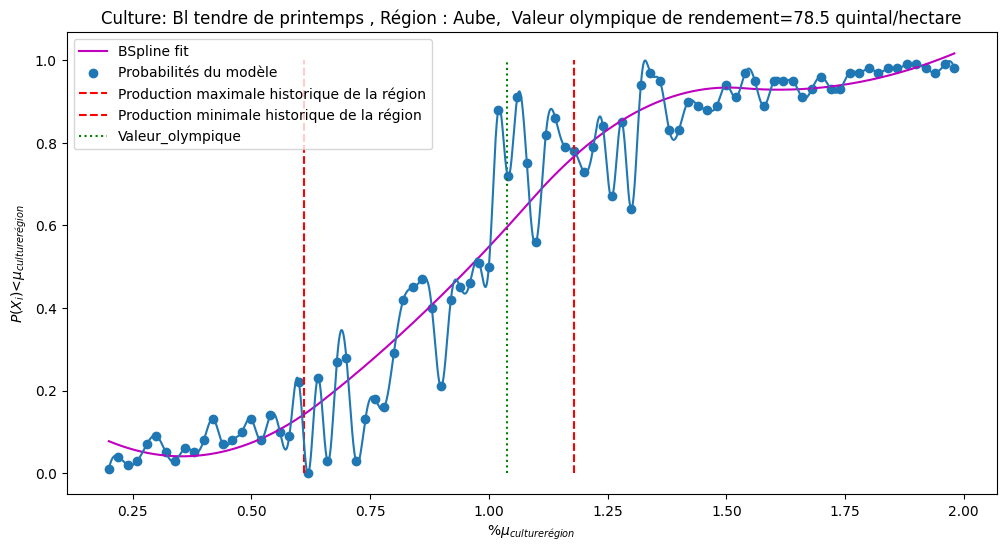

In [1228]:
import scipy.interpolate as interpolate
from scipy.interpolate import BSpline, splrep, splev


reg_filt_names=np.asarray(reg_names)[np.asarray(reg_filt).astype(int)]

N=5000
# 
choice=2
prob_region=np.asarray(prob_csv).T[choice] 

# prob_region_cut,portions_cut=cut_prob2(prob_region,portions,x_min_region[choice],x_max_region[choice])

items_remove,smooth_curve=remove_outliers(prob_region,portions)

# portions_out=np.delete(portions_cut,items_remove)
# prob_region_out=np.delete(prob_region_cut,items_remove)

t, c, k = interpolate.splrep(portions, prob_region, s=0, k=4)
# t, c, k = interpolate.splrep(portions, smooth_curve, s=0, k=4)


spline = interpolate.BSpline(t, c, k, extrapolate=False)

xmin, xmax =portions.min(), portions.max()
# xmin, xmax = portions_cut.min(), portions_cut.max()

xx = np.linspace(xmin, xmax, N)

n_interior_knots = 3
qs = np.linspace(0, 1, n_interior_knots+2)[1:-1]
knots = np.quantile(xx, qs)
tck = splrep(xx, spline(xx), t=knots, k=2)


ys_smooth = splev(xx, tck)

pred_likely=np.round(np.mean(xx[np.where(np.round(ys_smooth,2)==0.5)[0]])*100,2)

print('Prédiction de la production la plus probable: '+str(pred_likely)+'%')

# Display
plt.figure(figsize=(12, 6))
# plt.plot(xx, ys, '.c')
plt.plot(xx, ys_smooth, '-m',label='BSpline fit')
# plt.plot(portions,smooth_curve)
plt.scatter(portions,prob_region,label='Probabilités du modèle')
plt.plot(xx,spline(xx))
pred_olymp=np.where(ys_smooth==val_olymp_region[choice]*0.7)[0]

plt.ylabel(r'$P(X_{i})$<$\mu_{culture région}$')
plt.xlabel(r'$\%\mu_{culture région}$')
plt.title('Culture: '+str(culture_name)+' , Région : '+  str(reg_filt_names[choice])+',  Valeur olympique de rendement='+str(np.round(olymp_abs[choice],2))+' quintal/hectare')

plt.vlines(x_max_region[choice],0,1,label='Production maximale historique de la région',colors='r',linestyles='dashed')
plt.vlines(x_min_region[choice],0,1,label='Production minimale historique de la région',colors='r',linestyles='dashed')
plt.vlines(val_olymp_region[choice],0,1,label='Valeur_olympique',colors='g',linestyles='dotted')

plt.legend()
plt.show()


In [1218]:
prod_france_year_fit=[]
prod_france_year_model=[]
N=10000
for choice in range(len(np.asarray(prob_csv).T)):
    
    most_prob=[] 

    #####

    prob_region=np.asarray(prob_csv).T[choice] 

    items_remove,smooth_curve= remove_outliers(prob_region,portions)
    smooth_curve= remove_outliers2(prob_region,portions)
    
    ext_remove=[]
    ext_remove.append(np.where(np.round(prob_region,2)==0)[0])
    # ext_remove.append(np.where(np.round(prob_region,4)==0.5)[0])
    ext_remove.append(np.where(np.round(prob_region,2)==1)[0])
    ext_remove=np.hstack(ext_remove)
    prob_region2=np.delete(prob_region,ext_remove)
    portions2=np.delete(portions,ext_remove)

    t, c, k = interpolate.splrep(portions, prob_region, s=0, k=4)
    # t, c, k = interpolate.splrep(portions, smooth_curve, s=0, k=4)
    # t, c, k = interpolate.splrep(portions2, prob_region2, s=0, k=4)

    # spline = interpolate.BSpline(t, c, k, extrapolate=False)
        
    xmin, xmax =portions.min(), portions.max()
    # xmin, xmax =portions2.min() ,portions2.max()

    xx = np.linspace(xmin, xmax, N)

    n_interior_knots = 3
    qs = np.linspace(0, 1, n_interior_knots+2)[1:-1]
    knots = np.quantile(xx, qs)
    tck = splrep(xx, spline(xx), t=knots, k=2)
    ys_smooth = splev(xx, tck)
  
    prediction_rendement=np.nanmean(xx[np.where(np.round(ys_smooth,3)==0.5)[0]])*mean_regions[choice]
    prediction_rendement_model=np.nanmean(xx[np.where(np.round(spline(xx),3)==0.5)[0]])*mean_regions[choice]

    
    prod_france_year_fit.append(prediction_rendement)
    prod_france_year_model.append(prediction_rendement_model)
    
print('Prédiction smooth_Bspline du rendement moyen :', np.round(np.nanmean(prod_france_year_fit),1), 'quintals/h')
print('Prédiction Bspline du rendement moyen:', np.round(np.nanmean(prod_france_year_model),1), 'quintals/h')


Prédiction smooth_Bspline du rendement moyen : 55.5 quintals/h
Prédiction Bspline du rendement moyen: 56.0 quintals/h


In [1219]:
mean_rms,std_rms,min_rms,max_rms,rms,rms_noabs=rms_prod_model(prod_france_year_fit,rendement,year_choice)

# print(culture_name)
print(mean_rms)
print(std_rms)
print(min_rms)
print(max_rms)

7.311063821910153
6.062241794810369
0.17261983341192888
28.199355335533568


In [1232]:
year_choice=2013
score70,score80=accuracy_prod_assur(prod_france_year_fit,rendement,year_choice)

print(score70,score80)

0.08695652173913043 0.08695652173913043


(array([6., 4., 5., 4., 2., 1., 0., 0., 0., 1.]),
 array([ 0.17261983,  2.97529338,  5.77796693,  8.58064048, 11.38331403,
        14.18598758, 16.98866113, 19.79133468, 22.59400824, 25.39668179,
        28.19935534]),
 <BarContainer object of 10 artists>)

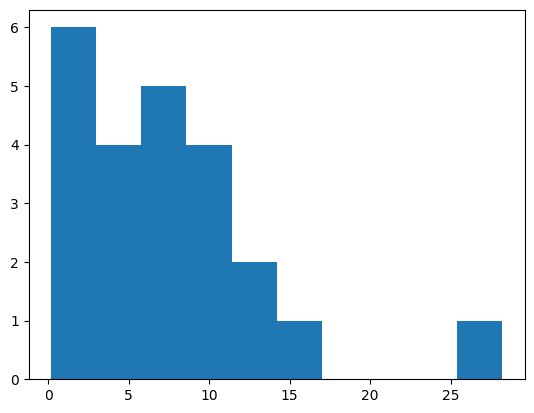

In [ ]:
plt.hist(rms)

<AxesSubplot:ylabel='Density'>

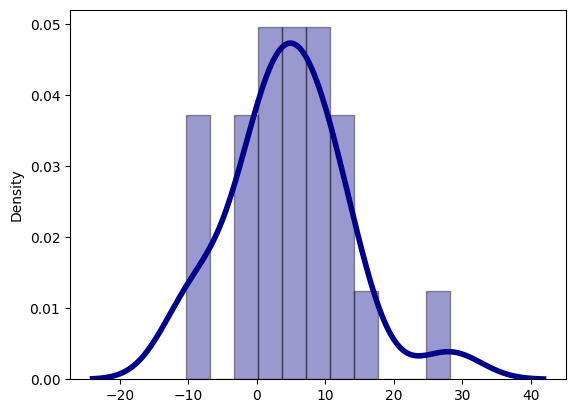

In [1221]:
import seaborn as sns

sns.distplot(rms_noabs,  hist=True, kde=True, 
             bins=int(len(rms)/2), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})


In [ ]:
score70,score80=accuracy_prod_assur(predictions,rendement,year_choice)

print(score70,score80)

In [1227]:
prod_france_year_fit

[69.8821862471961,
 33.28891074821766,
 70.8186458931607,
 36.20977297729771,
 67.82643435772147,
 34.82738016658807,
 38.80064466446643,
 51.95121369279783,
 55.340305744860174,
 57.21322503678937,
 59.08614432871856,
 54.403846098895585,
 73.52100087151571,
 50.36815095795291,
 70.85877987798777,
 68.49979343648647,
 49.409394653751065,
 70.76959324503876,
 72.64251253696796,
 53.199826554083955,
 54.72491797751202,
 49.27115537268011,
 33.71254725472546]

In [ ]:

steps_olymp=np.arange(0.4,1,0.05)

val_probs=[]
for step in steps_olymp:
    idx_pred_olymp=np.where(np.round(xx,2)==np.round(val_olymp_region[choice]*step,2))[0]
    val_probs.append(np.round(np.mean(ys_smooth[idx_pred_olymp])*100,2))

val_probs

[9.22,
 16.01,
 22.46,
 28.59,
 35.75,
 41.14,
 46.17,
 50.87,
 56.26,
 60.2,
 63.81,
 67.08]